In [1]:
from disk_utils_jax import jax_model, jax_model_scal
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

from jaxopt import ScipyMinimize

## Defining Disk and SPF Parameters

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [18]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.5, 'g2': 0.5, 'weight': 0.5})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:00.009130
0:00:00.002113


In [19]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

## Running Optimizations with more Parameters

In [20]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spf params, 0: g1, 1: g2, 2: weight
spf_params_jax = jnp.array([0.5, 0.5, 0.5])

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))

### Checking if log-likelihood method works

In [21]:
from regression import log_likelihood_1d_pos_all_pars
jax.config.update("jax_debug_nans", True)

# If nans are seen, Jax Opt won't work
llp = lambda x: log_likelihood_1d_pos_all_pars(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

grad_func = jax.grad(llp, argnums=(0))

print(grad_func(all_pars))

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(mul). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

In [22]:
solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
soln_sm, ignore = solver.run(init_params=all_pars)

disk_fit_jaxopt = {'alpha_in': soln_sm[0], 'alpha_out': soln_sm[1], 'sma': soln_sm[2], 'inclination': soln_sm[3], 'position_angle': soln_sm[4]}


Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(mul). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

### Likelihood Results

In [13]:
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

JAX Optimization Disk Parameters: {'alpha_in': Array(8., dtype=float32), 'alpha_out': Array(-5., dtype=float32), 'sma': Array(30., dtype=float32), 'inclination': Array(60., dtype=float32), 'position_angle': Array(50., dtype=float32)}{'g1': Array(0.5, dtype=float32), 'g2': Array(-0.5, dtype=float32), 'weight': Array(0.5, dtype=float32)}
Log-Likelihood: 130235.66
Actual Disk Parameters: {'inclination': 40.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}{'g1': 0.5, 'g2': -0.3, 'weight': 0.7}
Log-Likelihood: 86412.69


### Image Comparisions

In [14]:
disk_fit_jaxopt['flux_scaling'] = 1e6
spf_params_jaxopt = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])

print(disk_fit_jaxopt)
print(spf_params_jaxopt)

disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params=DoubleHenyeyGreenstein_SPF.unpack_pars(spf_params_jax))

disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params=spf_params_jaxopt)

{'alpha_in': Array(8., dtype=float32), 'alpha_out': Array(-5., dtype=float32), 'sma': Array(30., dtype=float32), 'inclination': Array(60., dtype=float32), 'position_angle': Array(50., dtype=float32), 'flux_scaling': 1000000.0}
{'g1': Array(0.5, dtype=float32), 'g2': Array(-0.5, dtype=float32), 'weight': Array(0.5, dtype=float32)}


Text(0.5, 1.0, 'Target Model')

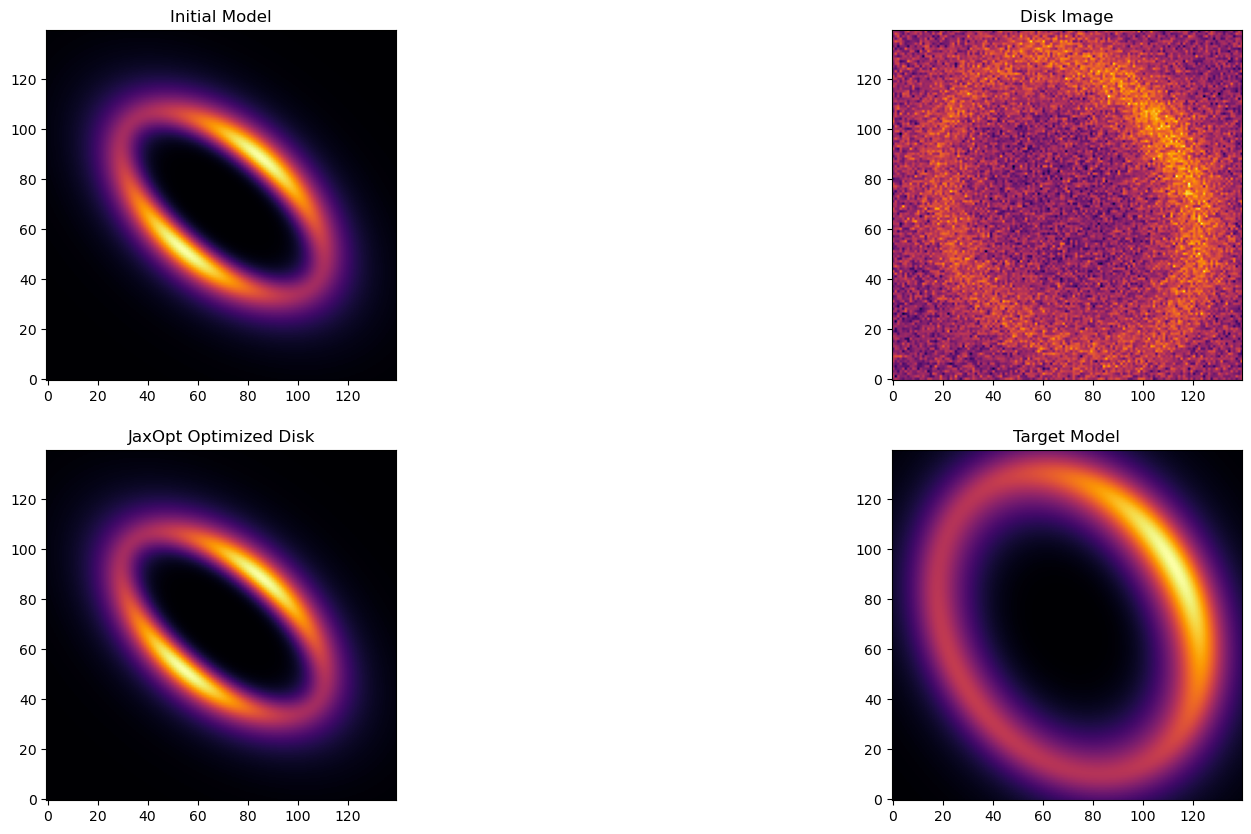

In [15]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0][0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[1][0].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][0].set_title("JaxOpt Optimized Disk")

axes[1][1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1][1].set_title("Target Model")

In [ ]:
solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
def jax_optimization_test():
    res = solver.run(init_params=all_pars)

#### Testing Runtimes

In [ ]:

%timeit jax_optimization_test()

2.29 s ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
